In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.set_device(0)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
type(testloader)

torch.utils.data.dataloader.DataLoader

In [6]:
len(trainloader)

12500

truck plane truck  frog


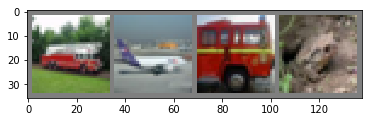

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 5 Layers : 2 conv layers and 3 fully connected layers !
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Create an instance of the model on CUDA
net = Net().cuda()

# To see if the model is on CUDA or not !
if (next(net.parameters()).is_cuda) :
    print("The model is on CUDA")
else :
    print("The model is on CPU")

# Import the optimizers 
import torch.optim as optim

# Declare a loss function
criterion = nn.CrossEntropyLoss()

# Declare an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#No of iterations !
iterations = 10


for epoch in range(iterations):  # loop over the dataset multiple times
    
    # Reset the loss for the current epoch !
    running_loss = 0.0
    
    # Loop over all the mini-batches !
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable & if possible make them cuda tensors
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients for the current epoch
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Calculate gradients of whatever variable set to req_gardients = True
        loss.backward()
        
        # Take one step of the gradient descent for this epoch !
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

The model is on CUDA
[1,  2000] loss: 2.216
[1,  4000] loss: 1.869
[1,  6000] loss: 1.679
[1,  8000] loss: 1.570
[1, 10000] loss: 1.518
[1, 12000] loss: 1.465
[2,  2000] loss: 1.392
[2,  4000] loss: 1.359
[2,  6000] loss: 1.335


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(Variable(images).cuda())

In [ ]:
_, predicted = torch.max(outputs.data, 1)

In [ ]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
import sys # For sys.exit() I have used somewhere

## What is the train set accuracy , <br> this information is requied to check if the model is overfitting ?

In [ ]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
for i, data in enumerate(trainloader, 0):
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    if (i%1000) == 0:
        print(i)

print('Accuracy of the network on the 50000 trained images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))